# Homework 2 | PSTAT134 | API's & Webscraping
____

## Part One: Analyzing the Weather
In this section, you will gain more practice working with public APIs, this time using a public weather API, [WeatherAPI](https://www.weatherapi.com/). The first thing you'll need to access this is an API key which you can sign up for [here](https://www.weatherapi.com/signup.aspx).

### Exercise 1
Use the [http://api.weatherapi.com/v1/current.json](https://api.weatherapi.com/v1/current.json) URL to access the API and obtain real-time weather data. Note that you will want to specify three query parameters, at least - **key**, which should be set to your individual API key, **q**, which should equal the latitude and longitude of a specified location - for example **q = "34.432961, -119.856870"**  - and **aqi**, which indicates whether you want to obtain air quality data ("yes" or "no").

Obtain current real-time weather data for fifty randomly selected locations. Use the cities within the cities.csv file.

In [166]:
import requests #Library to pull info
import api_key_holder #Reference to api_key so we don't publicize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [154]:
#Location list
locations_df = pd.read_csv('data/cities.csv')
locations = locations_df['names'].tolist()

#Prep key and url ref. for request
base_url = "http://api.weatherapi.com/v1/current.json"
api_key = api_key_holder.weatherapi_key

### Exercise 2
Write code in Python to extract and store the following data for each location (see orig.)

In [212]:
weather_data = [] #init

for loc in locations:
    parameters = {
        'key': api_key,
        'q': loc,
        'aqi': 'yes'
    }
    response = requests.get(base_url, parameters)
    data = response.json()
    entry_current = {"City_Name": data['location']['name'],
              "Country": data['location']['country'],
              "Daytime": data['current']['is_day'],
              "Temperature (f)": data['current']['temp_f'],
              "Humidity": data['current']['humidity'],
              "Weather_Desc": data['current']['condition']['text'],
              "Wind Speed (mph)": data['current']['wind_mph'],
              "Precipitation (mm)": data['current']['precip_mm'],
              "US_EPA_AQI": data['current']['air_quality']['us-epa-index']}
    weather_data.append(entry_current)

### Exercise 3
Create a scatterplot of temperature vs. humidity. Add a linear regression line to the plot. What are the estimated intercept and slope values for this linear regression? Does there appear to be a significant relationship between temperature and humidity?

In [215]:
from scipy.stats import linregress
df_weather = pd.DataFrame(weather_data) #convert for regression

slope, intercept, r_value, p_value, std_err = linregress(df_weather['Humidity'], df_weather['Temperature (f)'])
regression_line = slope * df_weather['Humidity'] + intercept

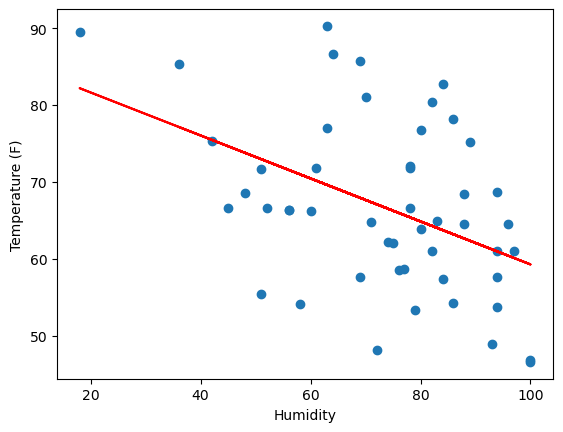

In [217]:
plt.scatter(x = df_weather['Humidity'] , y = df_weather['Temperature (f)'])
regression_line = slope * df_weather['Humidity'] + intercept
plt.plot(df_weather['Humidity'], regression_line, color='red', label="Regression Line")
plt.xlabel("Humidity"), plt.ylabel("Temperature (F)");

> Given the linear regression line, we see an intercept of 87.23 degrees F, and a slope of -0.2795. This suggests that as humidity increases, temperature tends to drop (however general domain knowledge of physics would indicated that as temperature drops, the relative humidity increases as colder air is able to hold onto less moisture). Meanwhile, with an r_value of -0.4499, this suggests that there is a weak-moderate negative relationship between temperature and humidity as mentioned earlier.

### Exercise 4 
Create a bar chart of the EPA air quality index values. What does the distribbution of air quality look like? Identify the locations(s) with the best and worst air quality.

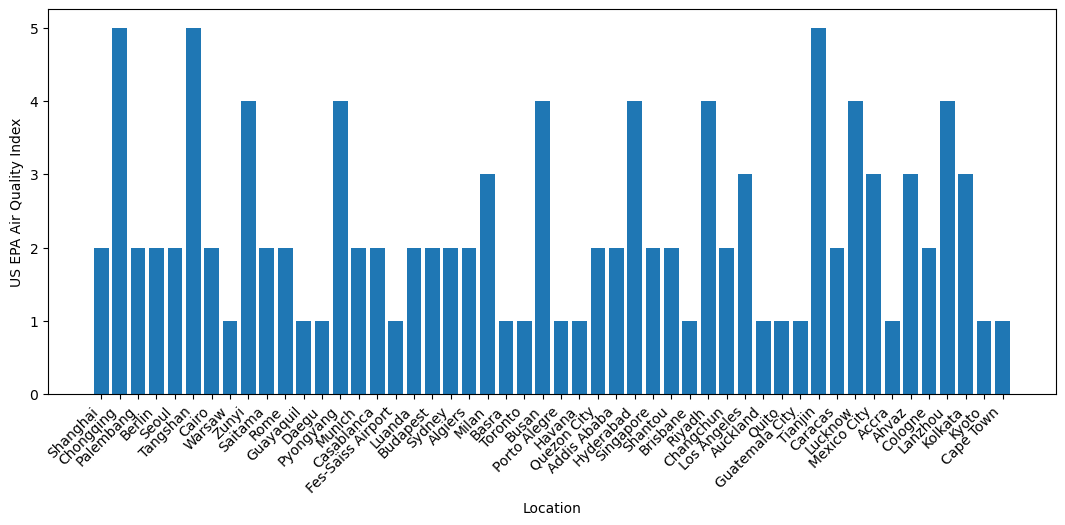

In [280]:
plt.figure(figsize=(13,5)), plt.bar(df_weather['City_Name'], df_weather['US_EPA_AQI']), 
plt.xlabel('Location'), plt.ylabel('US EPA Air Quality Index'), plt.xticks(rotation=45, ha='right');

In [262]:
bad_aqi = df_weather[df_weather["US_EPA_AQI"] > 3]
bad_aqi[['City_Name','Country', 'US_EPA_AQI']]

,City_Name,Country,US_EPA_AQI
1,Chongqing,China,5
5,Tangshan,China,5
8,Zunyi,China,4
13,Pyongyang,North Korea,4
24,Busan,Pakistan,4
29,Hyderabad,India,4
33,Riyadh,Saudi Arabia,4
39,Tianjin,China,5
41,Lucknow,India,4
46,Lanzhou,China,4


In [270]:
good_aqi = df_weather[df_weather["US_EPA_AQI"] < 2]
good_aqi[['City_Name','Country', 'US_EPA_AQI']]

,City_Name,Country,US_EPA_AQI
7,Warsaw,Poland,1
11,Guayaquil,Ecuador,1
12,Daegu,South Korea,1
16,Fes-Saïss Airport,Morocco,1
22,Basra,Iran,1
23,Toronto,Canada,1
25,Porto Alegre,Brazil,1
26,Havana,Cuba,1
32,Brisbane,Australia,1
36,Auckland,New Zealand,1


> Due to the sheer amount of locations displayed on the graph, it may be a bit difficult to interpret accurately so I've created the above dataframes as well. We see a slightly sporadic distribution of air qualities with AQI values of 1-2 being the most common while AQI values of 4-5 were quite rare. We see locations in China had the worst AQI with only Chinese cities like Chongqing, Tangshan, and Tianjin reaching values of 5. India, Saudi Arabia, North Korea, and Pakistan were the only other countries that had a city/cities with AQI scores over 3. Meanwhile, for the locations with the best air quality we see Brisbane, Guatemala City, Kyoto, and Basra to name a few. Note, these current values of AQI are subject to change and the interpretations from this document are only appropriate at the given time in which this was queried (Oct 31st 9:45 PCT).

### Exercise 5
Create a bar chart of the current weather description. Which conditions are the most common? Which are the least?


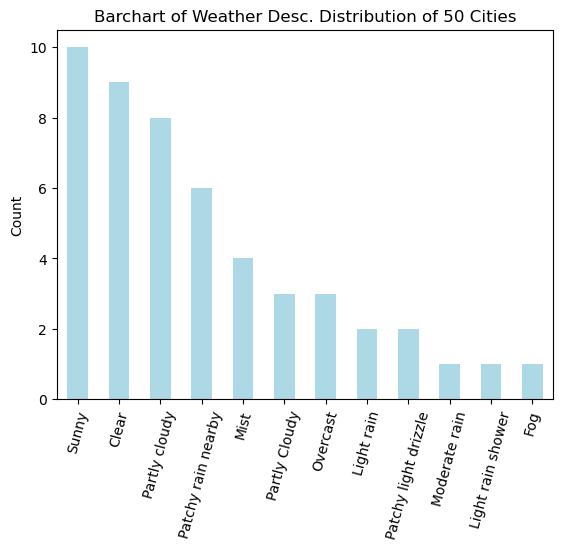

In [319]:
weather_counts = df_weather["Weather_Desc"].value_counts()

weather_counts.plot(kind = 'bar', color = 'lightblue')
plt.title("Barchart of Weather Desc. Distribution of 50 Cities")
plt.ylabel("Count"), plt.xticks(rotation = 75);

> Based on the chart above we see that Sunny, Clear, and Partly cloudly are the most common conditions, while Fog, Light rain shower, and moderate rain were the least common city conditions at the time of this query.

____

## Part Two: Scraping Books
In this section, we'll practice our web scraping skills by experimenting with a fictional online bookstore located [here](https://books.toscrape.com/).

### Exercise 9
Scrape the first 20 resultes from this site. Create a data frame that stores the following for each book:
- Title
- Price (excluding tax)
- Star rating
- Whether the book is in stock

In [322]:
from bs4 import BeautifulSoup

In [528]:
url = "https://books.toscrape.com/"

response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
book_pods = soup.find_all("article", class_ = "product_pod")

book_df = []
titles = []
prices = []
ratings = []
availability = []

In [530]:
for book in book_pods:
    #book titles
    title = book.h3.a['title']
    titles.append(title)
    #book prices
    price = book.find('p', class_= "price_color").text.strip().replace("£", "")
    prices.append(price)
    #book ratings
    rating = book.p['class'][1]
    rating_map = {"One": 1, "Two": 2, "Three": 3, "Four": 4, "Five": 5}
    ratings.append(rating_map.get(rating, 0))
    #book availability
    status = book.find("p", class_="instock availability").text.strip()
    availability.append(status)

book_df = pd.DataFrame({"Title": titles,
                       "Price": prices,
                       "Rating": ratings,
                       "Availability": availability})


book_df['Rating'] = pd.Categorical(book_df['Rating'], categories=[1, 2, 3, 4, 5], ordered=True)

In [532]:
book_df

,Title,Price,Rating,Availability
0,A Light in the Attic,51.77,3,In stock
1,Tipping the Velvet,53.74,1,In stock
2,Soumission,50.10,1,In stock
3,Sharp Objects,47.82,4,In stock
4,Sapiens: A Brief History of Humankind,54.23,5,In stock
5,The Requiem Red,22.65,1,In stock
6,The Dirty Little Secrets of Getting Your Dream...,33.34,4,In stock
7,The Coming Woman: A Novel Based on the Life of...,17.93,3,In stock
8,The Boys in the Boat: Nine Americans and Their...,22.60,4,In stock
9,The Black Maria,52.15,1,In stock


### Exercise 10
Create a histogram of prices for these 20 books. What is the average price?

Average Price: £38.05


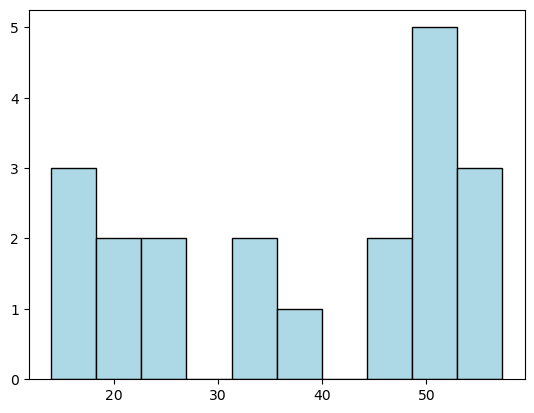

In [537]:
book_df['Price'] = pd.to_numeric(book_df['Price'])

plt.hist(book_df['Price'], bins = 10, color = 'lightblue', edgecolor = 'black');

average_price = book_df['Price'].mean()
print(f"Average Price: £{average_price:.2f}")

### Exercise 11
Create a bar chart of star rating for these 20 books. Find the book(s) with the highest and lowest star ratings.

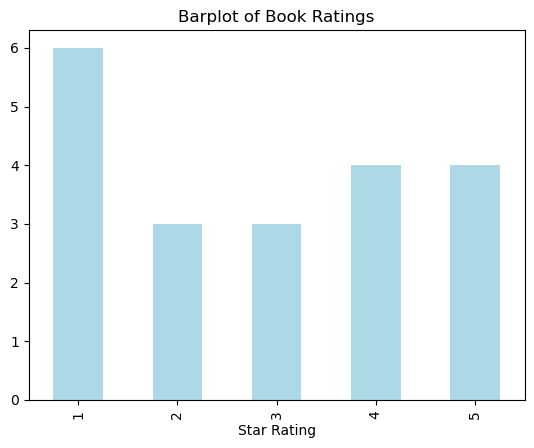

In [542]:
rating_counts = book_df['Rating'].value_counts().sort_index()
rating_counts.plot(kind = 'bar', color = 'lightblue')
plt.title("Barplot of Book Ratings"), plt.xlabel("Star Rating");

In [546]:
#Finding lowest rated books
one_star = book_df[book_df['Rating'] == 1]
one_star

,Title,Price,Rating,Availability
1,Tipping the Velvet,53.74,1,In stock
2,Soumission,50.10,1,In stock
5,The Requiem Red,22.65,1,In stock
9,The Black Maria,52.15,1,In stock
16,Olio,23.88,1,In stock
17,Mesaerion: The Best Science Fiction Stories 18...,37.59,1,In stock


In [548]:
#Finding highest rated books
five_star = book_df[book_df['Rating'] == 5]
five_star

,Title,Price,Rating,Availability
4,Sapiens: A Brief History of Humankind,54.23,5,In stock
12,Set Me Free,17.46,5,In stock
13,Scott Pilgrim's Precious Little Life (Scott Pi...,52.29,5,In stock
14,Rip it Up and Start Again,35.02,5,In stock
